In [39]:
# ! pip install gdown scikit-image
# !gdown --id 1bKTxbmtcd08H4Uw9UMzdft1Vhh-OwpFT
# !gdown --id 1Nccq3i-8pnZMHDsAO_UBYKsaFG9NR9hh

In [40]:
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import cv2
from sklearn.cluster import KMeans
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
import math
import random

import warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [41]:
def load_dataset():
    image_pickle_file_path = './images.pkl'
    label_pickle_file_path = './label.pkl'

    with open(image_pickle_file_path, 'rb') as file:
        images = pickle.load(file)

    with open(label_pickle_file_path, 'rb') as file:
        labels = pickle.load(file)

    return images, labels

In [42]:
images, labels = load_dataset()
# random_index = random.sample(list(range(images.shape[0])), 200)
# images = images[random_index]
# labels = [labels[idx] for idx in random_index]

## Image Segmentation

In [43]:
def super_pixel(image):
    image_height, image_width = image.shape[0], image.shape[1]
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    image_hue = image_hsv[:,:,0] / 179.0
    image_sat = image_hsv[:,:,1] / 255.0
    image_val = image_hsv[:,:,2] / 255.0

    color_features = [image_hue, image_sat, image_val]
    color_features_std = np.array([f.std() for f in color_features])
    high_contrast_feature = color_features[np.argmax(color_features_std)]

    number_of_features = 11
    image_pixel_featues = np.zeros((image_height,image_width,number_of_features), dtype=float)
    # Color features
    image_pixel_featues[:,:,0] = high_contrast_feature
    image_pixel_featues[:,:,1] = image_val
    image_pixel_featues[:,:,2] = image_sat
    image_pixel_featues[:,:,3] = image_val
    image_pixel_featues[:,:,4] = image_sat
    image_pixel_featues[:,:,5] = image_hue
    image_pixel_featues[:,:,6] = image_hue
    image_pixel_featues[:,:,7] = image_hue
    image_pixel_featues[:,:,8] = image_hue

    # Position features
    for i in range(image_height):
        image_pixel_featues[i,:,9] = math.fabs(i / float(image_height) - 0.5)
    for i in range(image_width):
        image_pixel_featues[:,i,10] = math.fabs(i / float(image_width) - 0.5)

    pixel_features = image_pixel_featues.reshape((image_height*image_width,number_of_features))

    # Clsster pixel features
    clustering = KMeans(n_clusters=3).fit(pixel_features)
    labels = clustering.labels_

    return labels.reshape(image_height, image_width)

In [44]:
image_super_pixels = np.zeros((images.shape[0],499,499), int)

for i in tqdm(range(images.shape[0])):
    image_super_pixels[i,:,:] = super_pixel(images[i])

100%|██████████| 560/560 [20:04<00:00,  2.15s/it]


## Region Feature Extraction

In [45]:
def super_pixel_feature_extractor(image, image_super_pixel, k):
    number_of_features = 17
    features = np.zeros((k, number_of_features))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    for i in range(k):
        cluster_mask = image_super_pixel == i
        pixels = image[cluster_mask]
        pixels_x, pixels_y = np.where(image_super_pixel == i)
        pixels_x = pixels_x / image.shape[1]
        pixels_y = pixels_y / image.shape[0]

        features[i,0] = pixels.shape[0] / (image.shape[0]*image.shape[1])
        v = pixels[:,2] / 255.0
        features[i,1] = v.std()
        features[i,2] = v.mean()
        features[i,3] = v.mean()
        s = pixels[:,1] / 255.0
        features[i,4] = s.std()
        features[i,5] = s.mean()
        features[i,6] = s.std()
        h = pixels[:,0] / 179.0
        features[i,7] = h.std()
        features[i,8] = h.mean()
        features[i,9] = h.std()
        features[i,10] = h.mean()
        features[i,11] = h.std()
        features[i,12] = h.mean()
        features[i,13] = pixels_x.mean()
        features[i,14] = pixels_x.std()
        features[i,15] = pixels_y.mean()
        features[i,16] = pixels_y.std()

    return features

In [46]:
images_features = np.empty((0,17), float)

for i in tqdm(range(images.shape[0])):
    image = images[i]
    img_feat = super_pixel_feature_extractor(image, image_super_pixels[i], 3)

    images_features = np.append(images_features, img_feat, axis=0)
    
images_features = images_features.reshape(images.shape[0],3,17)
print(images_features.shape)

100%|██████████| 560/560 [00:14<00:00, 38.22it/s]

(560, 3, 17)


## Region Rank

In [47]:
def sort_region(images, super_pixels, features, labels, regions):
  priority, mean_features = [[] for i in range(super_pixels.shape[0])], []
  exist = [list(range(regions)) for i in range(super_pixels.shape[0])]
  clf = RandomForestClassifier(n_estimators=100, random_state=42)
  mean_features = [np.mean(f, axis=0) for f in features]
  clf.fit(mean_features, labels)

  for i in range(regions-1):
    for j in range(super_pixels.shape[0]):
      # print(f"j = {j}")
      probs = []
      for k in exist[j]:
        current_exist = [v for v in exist[j]]
        current_exist.remove(k)

        f_mean = np.mean(features[j, current_exist, :], axis=0)
        # print(f_mean)
        # print(current_exist, exist[j])
        # print("---------")
        # print((np.expand_dims(f_mean, 0)))
        # print("+++++++++")
        # print(f"fmean = {f_mean}")
        # print(f"prob = { clf.predict_proba(np.expand_dims(f_mean, 0))}")
        f_mean_prob = clf.predict_proba(np.expand_dims(f_mean, 0))[0][labels[j]]
        probs.append(f_mean_prob)

      # print(probs)
      max_index = np.argmax(np.array(probs))
      # print(max_index)
      priority[j].append(exist[j][max_index])
      exist[j].pop(max_index)
      mean_features[j] =  np.mean(features[j, exist[j], :], axis=0)

    clf.fit(mean_features, labels)

  for i in range(len(exist)):
    priority[i].append(exist[i][0])
    
  return priority


In [48]:
priority = sort_region(images, image_super_pixels, images_features, labels, 3)

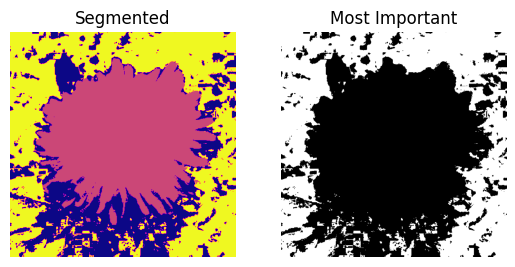

In [49]:
i = 174
array = np.zeros((499,499))
mask = image_super_pixels[i] ==  priority[i][-1]
array[mask] = 255

plt.subplot(1,2,1)
plt.axis('off')
plt.title('Segmented')
plt.imshow(image_super_pixels[i], cmap='plasma')

plt.subplot(1,2,2)
plt.axis('off')
plt.title('Most Important')
plt.imshow(array, cmap='gray')


## Feature Selection
### Select 80% Of Data

In [50]:
datapoints = np.array([images_features[i, priority[i][-1], :] for i in range(images_features.shape[0])])
print(datapoints.shape)

(560, 17)


In [51]:
def select_data(datapoints, labels, rate):
    labels = np.array(labels)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(datapoints, labels)
#     y_pred = clf.predict(datapoints)
#     print(y_pred)
#     print(clf.predict_proba(datapoints))
#     accuracy = accuracy_score(labels, y_pred)
#     print(accuracy)

    sample_class_probs = []
    
    for p,l in zip(clf.predict_proba(datapoints), labels):
        sample_class_probs.append(p[l])
        
    sample_class_probs = np.array(sample_class_probs)
    select = int(sample_class_probs.shape[0] * rate)
    indexes = np.argsort(sample_class_probs)[:select]
    
    return datapoints[indexes], labels[indexes]

In [52]:
selected_datapoints, selected_labels = select_data(datapoints, labels, 0.8)
print(selected_datapoints.shape)

(448, 17)


### Select Features

In [53]:
# Classify the datapoints with the Random Forest Classifier

def classify(datapoints, labels, plot=True):
    test_size = 0.2
    X_train, X_test, y_train, y_test, inedx_train, index_test = train_test_split(datapoints, labels, np.array(list(range(0,datapoints.shape[0]))), test_size=test_size, random_state=42)

    clf = RandomForestClassifier(n_estimators=100, random_state=42)

    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)

    # Confusion Matrix
    if plot:
        cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
        cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
        cm_display.plot()
        plt.show()
        # plt.savefig('confusion_matrix.png')

    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro')
    f1 = f1_score(y_test, y_pred, average='macro')
    
    if plot:
        print(f"Accuracy: {accuracy * 100:.2f}%")
        print(f"Recall: {recall * 100:.2f}%")
        print(f"F1 Score: {f1 * 100:.2f}%")

    wrong_mask = np.where(y_pred != y_test)[0]
    return wrong_mask, y_test, y_pred, index_test, accuracy

In [54]:
single_feature_accuracy = []

for i in range(selected_datapoints.shape[1]):
    mask, test_labels, test_preds, test_index, acc = classify(selected_datapoints[:, i].reshape(selected_datapoints.shape[0], 1), selected_labels, False)
    single_feature_accuracy.append(acc)

single_feature_accuracy = np.array(single_feature_accuracy)
print(single_feature_accuracy)

[0.17777778 0.22222222 0.27777778 0.27777778 0.18888889 0.23333333
 0.18888889 0.21111111 0.24444444 0.21111111 0.24444444 0.21111111
 0.24444444 0.16666667 0.24444444 0.17777778 0.17777778]


In [92]:
best_index = np.flip(np.argsort(single_feature_accuracy))
selected = []
last_acc = 0
not_better_step = 0

while 1:
    if len(selected) == 0:
        selected.append(best_index[0])
    else:
        corrs = []

        for i in range(best_index.shape[0]):
            feature_corrs = []
            for j in range(len(selected)):
                feature_corrs.append(np.abs(np.corrcoef(selected_datapoints[:, i], selected_datapoints[:, selected[j]])[0,1]))
            corrs.append(1. - np.array(feature_corrs).max())
            
        corrs = np.array(corrs)
        feature_scores = (2 * corrs * single_feature_accuracy) / (corrs + single_feature_accuracy)
        best_scores = np.flip(np.argsort(feature_scores))
        
        for idx in best_scores:
            if not idx in selected:
                selected.append(idx)
                break
            
    mask, test_labels, test_preds, test_index, acc = classify(selected_datapoints[:, selected].reshape(selected_datapoints.shape[0], len(selected)), selected_labels, False)
    
    if acc - last_acc < 0.01:
        not_better_step += 1
    else:
        not_better_step = 0

    if len(selected) == selected_datapoints.shape[1] or last_acc - acc > 0.02 or not_better_step == 2:
        break
    else:
        last_acc = acc    

selected = selected[:-1]

-0.2777777777777778 0 0.2777777777777778
-0.2 0.2777777777777778 0.4777777777777778
-0.04444444444444445 0.4777777777777778 0.5222222222222223
-0.05555555555555547 0.5222222222222223 0.5777777777777777
-0.05555555555555558 0.5777777777777777 0.6333333333333333
0.0 0.6333333333333333 0.6333333333333333
-0.033333333333333326 0.6333333333333333 0.6666666666666666
0.022222222222222143 0.6666666666666666 0.6444444444444445


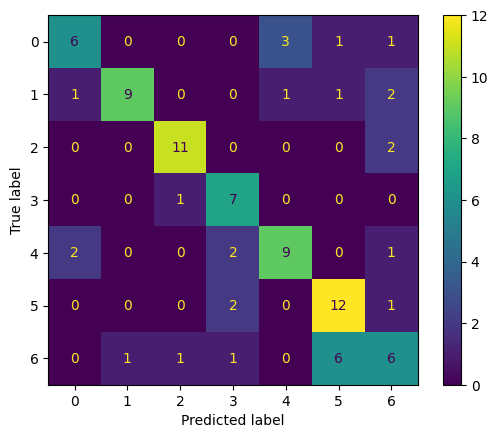

Accuracy: 66.67%
Recall: 67.89%
F1 Score: 66.82%


In [93]:
mask, test_labels, test_preds, test_index, acc = classify(selected_datapoints[:, selected].reshape(selected_datapoints.shape[0], len(selected)), selected_labels)

In [94]:
print(selected)

[3, 8, 5, 1, 14, 4, 9]


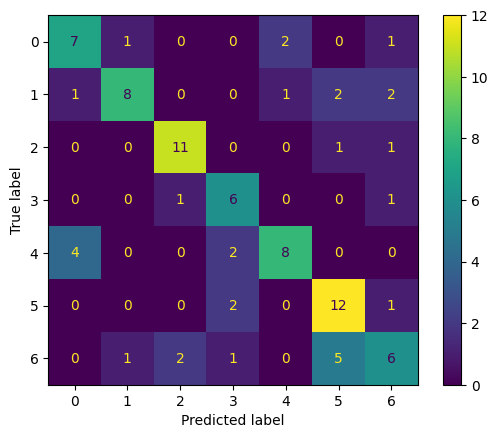

Accuracy: 64.44%
Recall: 65.36%
F1 Score: 64.17%


In [58]:
mask, test_labels, test_preds, test_index, acc = classify(selected_datapoints, selected_labels)